In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
#import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics
import scipy.stats as stats

plt.style.use('seaborn')
sns.set(font_scale=2)
pd.set_option('display.max_columns', 500)

In [50]:
def analysis(col):
    temp = train[col].value_counts()
    temp = temp[temp > temp.iloc[20]].index
    #temp = train.index
    temp_df = train[train[col].isin(temp)]
    #temp_df = temp_df.sample(1000)
    #temp_df = train
    p = temp_df.HasDetections.mean()
    q = 1-p
    random_data = pd.Series(np.random.choice([1,0], len(temp_df),p=[p,q]), index = temp_df.index).rename('HasDetections')
    temp_df['random_data'] = random_data
    
    #temp_df.groupby(col).HasDetections.mean().plot(kind = 'bar', figsize=(20,10))
    temp_df.groupby(col)[['HasDetections', 'random_data']].mean().plot(kind = 'bar', figsize=(20,10))
    plt.title('Percent of Has detections by {}'.format(col))
    
    display(pd.DataFrame({'train_data': temp_df.groupby(col).HasDetections.mean(),
                         'random_data': temp_df.groupby(col).random_data.mean()}))
    return stats.chi2_contingency([temp_df.groupby(col).HasDetections.mean(),
                temp_df.groupby(col).random_data.mean()])

In [17]:
COLS = [
    'HasDetections',
    'GeoNameIdentifier',
    'CountryIdentifier'
]

In [11]:
train = pd.read_csv("train.csv", sep=',', engine='c', usecols=COLS)

In [15]:
#top 20 contries analysis

,train_data,random_data
GeoNameIdentifier,,
10.0,0.511848,0.504213
35.0,0.507216,0.502518
52.0,0.510999,0.503345
53.0,0.517883,0.502149
57.0,0.540070,0.501434
89.0,0.473733,0.504135
98.0,0.452187,0.505104
119.0,0.495623,0.503420
120.0,0.592210,0.501268


(0.01714450954060008,
 1.0,
 19,
 array([[0.50762167, 0.504461  , 0.50676408, 0.50960563, 0.5203334 ,
         0.4885411 , 0.47826079, 0.49911999, 0.54629949, 0.49293231,
         0.49194832, 0.51299034, 0.49297681, 0.49049658, 0.50177147,
         0.50041532, 0.50463727, 0.50949676, 0.48410872, 0.50738056],
        [0.50843868, 0.50527292, 0.50757971, 0.51042583, 0.52117087,
         0.4893274 , 0.47903054, 0.49992331, 0.54717875, 0.49372567,
         0.4927401 , 0.51381599, 0.49377025, 0.49128602, 0.50257907,
         0.50122073, 0.50544948, 0.51031678, 0.48488789, 0.50819718]]))

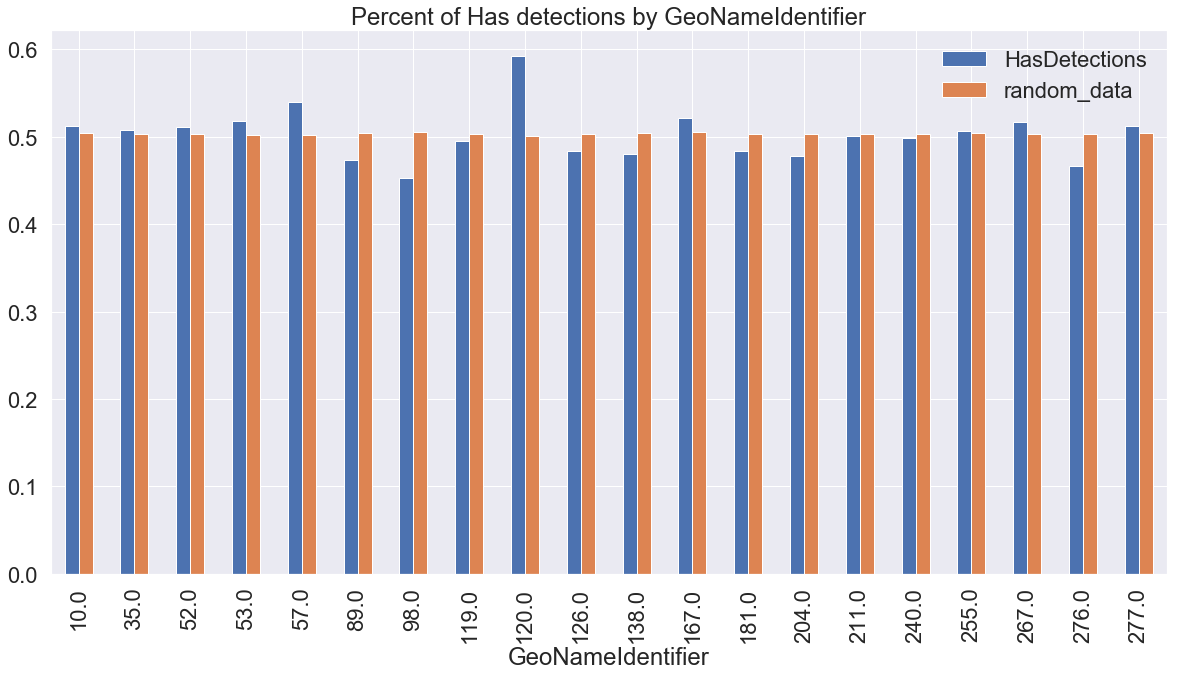

In [18]:
analysis(COLS[1])

In [19]:
#from the histogram, we see there is a difference in top 4 counties

,train_data,random_data
CountryIdentifier,,
9,0.506709,0.506901
29,0.505318,0.508737
41,0.507615,0.506612
43,0.512030,0.509835
44,0.533652,0.509285
51,0.478736,0.509972
60,0.492523,0.508589
66,0.484162,0.510018
68,0.479183,0.508941


(0.02079349922281052,
 1.0,
 19,
 array([[0.5068927 , 0.50711523, 0.50720156, 0.51102071, 0.52155905,
         0.49443969, 0.50064271, 0.49717586, 0.49414762, 0.54978194,
         0.50120616, 0.49620189, 0.49475415, 0.5140177 , 0.51407962,
         0.50249809, 0.50989006, 0.50308279, 0.49673837, 0.55742148],
        [0.50671728, 0.50693973, 0.50702604, 0.51084387, 0.52137855,
         0.49426858, 0.50046945, 0.4970038 , 0.49397661, 0.54959168,
         0.50103271, 0.49603017, 0.49458294, 0.51383981, 0.51390172,
         0.5023242 , 0.50971361, 0.50290869, 0.49656646, 0.55722857]]))

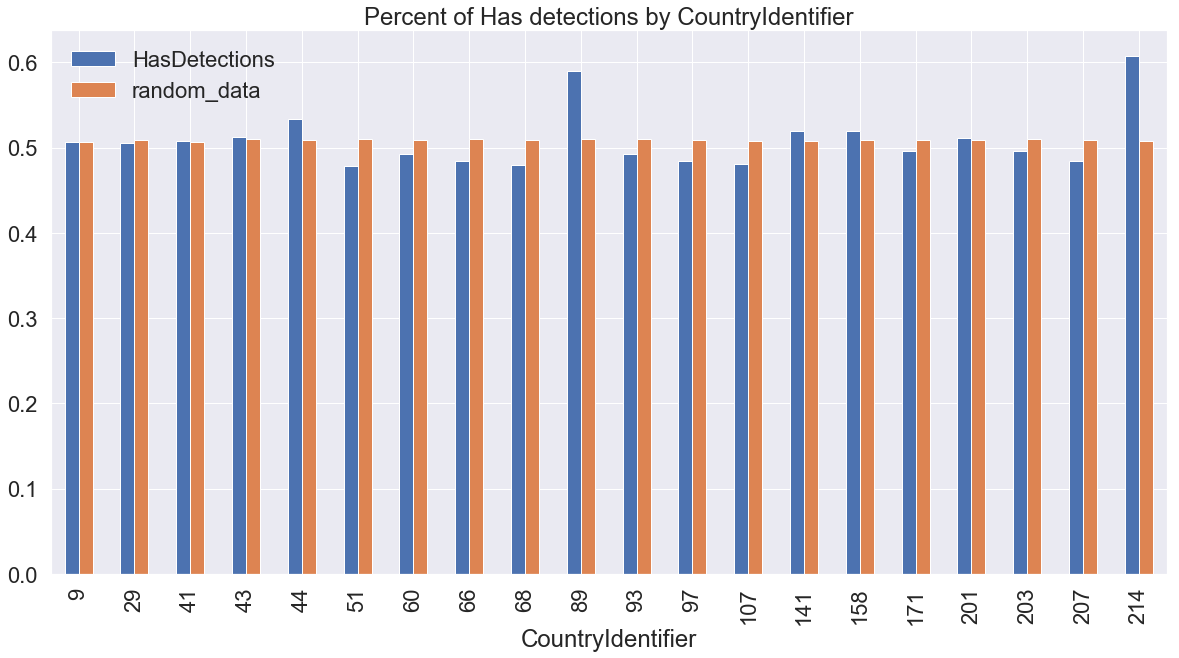

In [51]:
analysis(COLS[2])

In [54]:
# spotting from histogram, significant difference found. Do detailed investigation